# Recurrent Neural Networks

Gabs DiLiegro, London Kasper, Carys LeKander

Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?select=spam.csv

## Preparation

Our dataset is a collection of text messages that are identified as normal or spam texts.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv',encoding='latin-1')
df = df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


The first column of our dataset identifies if it is a spam text. We used label encoding below to change the column to be 0 for a normal text and 1 for a spam text. 

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = preprocessing.LabelEncoder()
le.fit(df['v1'])
df['v1'] = le.transform(df['v1'])

df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Looking at the totals for each category, we can see that there are many more normal text messages than spam messages in our dataset. 

In [3]:
totals = df['v1'].value_counts()
totals

0    4825
1     747
Name: v1, dtype: int64

The longest text message in our dataset is 171 which we will use for our max length during tokenization.


In [4]:
max_words = 0
for i in df.v2:
    if len(i.split()) > max_words:
        max_words = len(i.split())
max_words

171

For our tokenization, we converted each word to an integer using the Keras Tokenizer.

In [5]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = max_words # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df.v2)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df.v2)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
print('Shape of data tensor:', X.shape)
y = df.v1.astype(np.int32)

2022-12-14 12:41:38.872962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8920 unique tokens. Distilled to 8920 top words.
Shape of data tensor: (5572, 171)
CPU times: user 8.32 s, sys: 1.86 s, total: 10.2 s
Wall time: 20.1 s


For our business case, we want to notify users when they recieve a text that may be spam. If we misclassify something as spam, the user may be slightly annoyed. However, if we do not clasify something as spam when it is, it could lead to the user trusting a fraudulent text. Therefore we want to minimize the number of false negative (number of spam texts classified as normal texts), so we will use recall to measure our algorithm's performance.

We chose to use a Stratified 10-fold cross validation for dividing our data into training and testing. We chose this method because our dataset is smaller (5572) and there are not many examples of spam texts (747). We want to make sure that we represent the entire dataset in equal proportion.

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
y_train = y_train.values.astype(np.int32)
y_test = y_test.values.astype(np.int32)
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

## Modeling

For our modeling, we decided to investigate LSTM and GRU recurrent network architectures. To start, we used GloVe pre-trained embeddings.

In [7]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove.6b/glove.6B.100d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (8921, 100) 
 Total words found: 6518 
 Percentage: 73.06355789709674
CPU times: user 17.8 s, sys: 1.16 s, total: 18.9 s
Wall time: 23.7 s


In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM, GRU
from tensorflow.keras.layers import Embedding

In [9]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

Our first two models are LSTM models. We adjusted the hyper-parameters for the recurrent dropout for our second model. In our first model, the reccurent dropout is 0.2, while in the second model it is 0.3.

In [10]:
lstm1 = Sequential()
lstm1.add(embedding_layer)
lstm1.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
lstm1.add(Dense(1, activation='sigmoid'))

print(lstm1.summary())

2022-12-14 12:42:23.470605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 100)          892100    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 972,601
Trainable params: 80,501
Non-trainable params: 892,100
_________________________________________________________________
None


In [11]:
lstm2 = Sequential()
lstm2.add(embedding_layer)
lstm2.add(LSTM(100,dropout=0.2, recurrent_dropout=0.3))
lstm2.add(Dense(1, activation='sigmoid'))

print(lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 100)          892100    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 972,601
Trainable params: 80,501
Non-trainable params: 892,100
_________________________________________________________________
None


Our last two models are GRU models. We adjusted the hyper-parameters for the recurrent dropout for our fourth model. In our thrid model, the reccurent dropout is 0.2, while in the fourth model it is 0.3.

In [12]:
gru1 = Sequential()
gru1.add(embedding_layer)
gru1.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
gru1.add(Dense(1, activation='sigmoid'))

print(gru1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 100)          892100    
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 952,801
Trainable params: 60,701
Non-trainable params: 892,100
_________________________________________________________________
None


In [13]:
gru2 = Sequential()
gru2.add(embedding_layer)
gru2.add(GRU(100,dropout=0.2, recurrent_dropout=0.3))
gru2.add(Dense(1, activation='sigmoid'))

print(gru2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 100)          892100    
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 952,801
Trainable params: 60,701
Non-trainable params: 892,100
_________________________________________________________________
None


In [14]:
from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)

def roc(model, test, train, mean_tpr):
    probas = model.predict(X_train[test], verbose=0)
    fpr, tpr, thresholds = roc_curve(y_train[test], probas, pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    return mean_tpr

In [15]:
%%time
acc_per_fold1 = []
recall_per_fold1 = []
loss_per_fold1 = []
mean_tpr1 = 0.0

acc_per_fold2 = []
recall_per_fold2 = []
loss_per_fold2 = []
mean_tpr2 = 0.0

acc_per_fold3 = []
recall_per_fold3 = []
loss_per_fold3 = []
mean_tpr3 = 0.0

acc_per_fold4 = []
recall_per_fold4 = []
loss_per_fold4 = []
mean_tpr4 = 0.0

# K-fold Cross Validation model evaluation
for k, (train, test) in enumerate(kfold):

    # Compile the model
    lstm1.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy', keras.metrics.Recall()])
    lstm2.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy', keras.metrics.Recall()])
    gru1.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy', keras.metrics.Recall()])
    gru2.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy', keras.metrics.Recall()])


    # Generate a print
    print(f'Training for fold {k+1} ...')

    # Fit data to model
    history1 = lstm1.fit(X_train[train], y_train[train], epochs=3, batch_size=64, validation_data=(X_train[test], y_train[test],), verbose=0)
    history2 = lstm2.fit(X_train[train], y_train[train], epochs=3, batch_size=64, validation_data=(X_train[test], y_train[test],), verbose=0)
    history3 = gru1.fit(X_train[train], y_train[train], epochs=3, batch_size=64, validation_data=(X_train[test], y_train[test],), verbose=0)
    history4 = gru2.fit(X_train[train], y_train[train], epochs=3, batch_size=64, validation_data=(X_train[test], y_train[test],), verbose=0)

    mean_tpr1 = roc(lstm1, test, train, mean_tpr1)
    mean_tpr2 = roc(lstm2, test, train, mean_tpr2)
    mean_tpr3 = roc(gru1, test, train, mean_tpr3)
    mean_tpr4 = roc(gru2, test, train, mean_tpr4)

    # Generate generalization metrics
    scores1 = lstm1.evaluate(X_train[test], y_train[test], verbose=0)
    scores2 = lstm2.evaluate(X_train[test], y_train[test], verbose=0)
    scores3 = gru1.evaluate(X_train[test], y_train[test], verbose=0)
    scores4 = gru2.evaluate(X_train[test], y_train[test], verbose=0)

    print(f'Score for LSTM1: {lstm1.metrics_names[0]} of {scores1[0]}; {lstm1.metrics_names[1]} of {scores1[1]*100}%; {lstm1.metrics_names[2]} of {scores1[2]*100}%')
    print(f'Score for LSTM2: {lstm2.metrics_names[0]} of {scores2[0]}; {lstm2.metrics_names[1]} of {scores2[1]*100}%; {lstm2.metrics_names[2]} of {scores2[2]*100}%')
    print(f'Score for GRU1: {gru1.metrics_names[0]} of {scores3[0]}; {gru1.metrics_names[1]} of {scores3[1]*100}%; {gru1.metrics_names[2]} of {scores3[2]*100}%')
    print(f'Score for GRU2: {gru2.metrics_names[0]} of {scores4[0]}; {gru2.metrics_names[1]} of {scores4[1]*100}%; {gru2.metrics_names[2]} of {scores4[2]*100}%')

    loss_per_fold1.append(scores1[0])
    acc_per_fold1.append(scores1[1] * 100)
    recall_per_fold1.append(scores1[2]*100)
    loss_per_fold2.append(scores2[0])
    acc_per_fold2.append(scores2[1] * 100)
    recall_per_fold2.append(scores2[2]*100)
    loss_per_fold3.append(scores3[0])
    acc_per_fold3.append(scores3[1] * 100)
    recall_per_fold3.append(scores3[2]*100)
    loss_per_fold4.append(scores4[0])
    acc_per_fold4.append(scores4[1] * 100)
    recall_per_fold4.append(scores4[2]*100)


Training for fold 1 ...
Score for LSTM1: loss of 0.07279717922210693; accuracy of 97.98206090927124%; recall of 86.8852436542511%
Score for LSTM2: loss of 0.09602268040180206; accuracy of 97.53363132476807%; recall_1 of 86.8852436542511%
Score for GRU1: loss of 0.08886227756738663; accuracy of 97.30941653251648%; recall_2 of 85.24590134620667%
Score for GRU2: loss of 0.08136230707168579; accuracy of 97.53363132476807%; recall_3 of 85.24590134620667%
Training for fold 2 ...
Score for LSTM1: loss of 0.0837450847029686; accuracy of 97.53363132476807%; recall_4 of 88.52459192276001%
Score for LSTM2: loss of 0.07517705857753754; accuracy of 98.20627570152283%; recall_5 of 91.80327653884888%
Score for GRU1: loss of 0.06729728728532791; accuracy of 98.20627570152283%; recall_6 of 88.52459192276001%
Score for GRU2: loss of 0.07106711715459824; accuracy of 97.98206090927124%; recall_7 of 86.8852436542511%
Training for fold 3 ...
Score for LSTM1: loss of 0.034061234444379807; accuracy of 98.8789

**Discuss performance of models. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.**

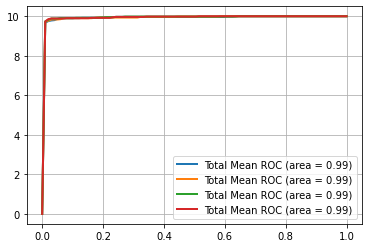

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

mean_tpr1a = mean_tpr1 / 10
mean_auc1 = auc(mean_fpr, mean_tpr1a)
plt.plot(mean_fpr,mean_tpr1,lw=2,label='LSTM1 Mean ROC (area = %0.2f)' % (mean_auc1))

mean_tpr2a = mean_tpr2 / 10
mean_auc2 = auc(mean_fpr, mean_tpr2a)
plt.plot(mean_fpr,mean_tpr2,lw=2,label='Total Mean ROC (area = %0.2f)' % (mean_auc2))

mean_tpr3a = mean_tpr3 / 10
mean_auc3 = auc(mean_fpr, mean_tpr3a)
plt.plot(mean_fpr,mean_tpr3,lw=2,label='Total Mean ROC (area = %0.2f)' % (mean_auc3))

mean_tpr4a = mean_tpr4 / 10
mean_auc4 = auc(mean_fpr, mean_tpr4a)
plt.plot(mean_fpr,mean_tpr4,lw=2,label='Total Mean ROC (area = %0.2f)' % (mean_auc4))

plt.legend(loc='best')
plt.grid()

In [ ]:
print("")

In [17]:
# Look at average accuracy and recall
avg_acc1 = np.average(acc_per_fold1)
avg_acc2 = np.average(acc_per_fold2)
avg_acc3 = np.average(acc_per_fold3)
avg_acc4 = np.average(acc_per_fold4)

avg_recall1 = np.average(recall_per_fold1)
avg_recall2 = np.average(recall_per_fold2)
avg_recall3 = np.average(recall_per_fold3)
avg_recall4 = np.average(recall_per_fold4)

print("Average Accurracy and Recall:")
print(f"LSTM 1: {avg_acc1}, {avg_recall1}")
print(f"LSTM 2: {avg_acc2}, {avg_recall2}")
print(f"GRU 1: {avg_acc3}, {avg_recall3}")
print(f"GRU 2: {avg_acc4}, {avg_recall4}")

Average Accurracy and Recall:
LSTM 1: 99.10313904285431, 95.90163946151733
LSTM 2: 99.10293817520142, 95.90163946151733
GRU 1: 99.32735443115234, 95.73770523071289
GRU 2: 99.26003932952881, 95.4071033000946


In [22]:
# mcnemar test
def mcnemar(y_pred1, y_pred2, y_actual):
    a,b,c = 0,0,0
    for i in range(y_actual.size):
        model1, model2 = False, False
        if y_pred1[i] == y_actual[i]:
            model1 = True
        if y_pred2[i] == y_actual[i]:
            model2 = True
        
        if model1 and model2:
            a += 1
        elif model1:
            b += 1
        elif model2:
            c += 1
    if(b-c == 0):
        return False
    
    if ((abs(b-c)-1)**2)/(b+c) > 3.841:
        return True
    return False

In [20]:
lstm1.fit(X_train, y_train, epochs=3, batch_size=64, verbose=1)
lstm2.fit(X_train, y_train, epochs=3, batch_size=64, verbose=1)
gru1.fit(X_train, y_train, epochs=3, batch_size=64, verbose=1)
gru2.fit(X_train, y_train, epochs=3, batch_size=64, verbose=1)

yhat_prob1 = lstm1.predict(X_test)
yhat_prob2 = lstm2.predict(X_test)
yhat_prob3 = gru1.predict(X_test)
yhat_prob4 = gru2.predict(X_test)

yhat1 = np.round(yhat_prob1)
yhat2 = np.round(yhat_prob2)
yhat3 = np.round(yhat_prob3)
yhat4 = np.round(yhat_prob4)

Epoch 1/3
70/70 [==============================] - 18s 249ms/step - loss: 0.0067 - accuracy: 0.9973 - recall_36: 0.9868
Epoch 2/3
70/70 [==============================] - 24s 338ms/step - loss: 0.0063 - accuracy: 0.9982 - recall_36: 0.9901
Epoch 3/3
70/70 [==============================] - 23s 325ms/step - loss: 0.0045 - accuracy: 0.9982 - recall_36: 0.9885
Epoch 1/3
70/70 [==============================] - 21s 299ms/step - loss: 0.0078 - accuracy: 0.9980 - recall_37: 0.9918
Epoch 2/3
70/70 [==============================] - 27s 393ms/step - loss: 0.0058 - accuracy: 0.9984 - recall_37: 0.9918
Epoch 3/3
70/70 [==============================] - 22s 311ms/step - loss: 0.0051 - accuracy: 0.9989 - recall_37: 0.9934
Epoch 1/3
70/70 [==============================] - 19s 266ms/step - loss: 0.0045 - accuracy: 0.9987 - recall_38: 0.9967
Epoch 2/3
70/70 [==============================] - 20s 279ms/step - loss: 0.0032 - accuracy: 0.9991 - recall_38: 0.9967
Epoch 3/3
70/70 [=======================

In [33]:
print("McNemar Tests")
print(f"LSTM1 vs. LSTM2: {mcnemar(yhat1,yhat2,y_test)}")
print(f"GRU1 vs. GRU2: {mcnemar(yhat3,yhat4,y_test)}")
print(f"LSTM1 vs. GRU1: {mcnemar(yhat1,yhat3,y_test)}")
print(f"LSTM2 vs. GRU2: {mcnemar(yhat2,yhat4,y_test)}")
print(f"LSTM1 vs. GRU2: {mcnemar(yhat1,yhat4,y_test)}")
print(f"GRU1 vs. LSTM2: {mcnemar(yhat3,yhat2,y_test)}")

McNemar Tests
LSTM1 vs. LSTM2: False
GRU1 vs. GRU2: False
LSTM1 vs. GRU1: False
LSTM2 vs. GRU2: False
LSTM1 vs. GRU2: False
GRU1 vs. LSTM2: True
